In [ ]:
import random
import os
import shutil

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Storing file names of masks and embryos

In [ ]:
file_names = os.listdir('drive/MyDrive/Data_Embryo_Mask')
mask = []
embryo = []

for fname in file_names:
  # Mask_1611.jpg is curropted
  if fname=='Mask_1611.jpg' or fname=='Embryo_1611.jpg':
    continue
  mask.append('data/Mask/'+fname) if fname.startswith('Mask') else embryo.append('data/Embryo/'+fname)

embryo.sort()
mask.sort()

Copying images to local folder from drive

In [ ]:
for label in ['Mask', 'Embryo']:
  os.makedirs('data/'f'{label}')
  img_paths = ['drive/MyDrive/Data_Embryo_Mask/'f'{label}_{i}.jpg' for i in range(len(mask)+1)]
  for img_path in img_paths:
    shutil.copy2(img_path, 'data/'f'{label}')

# Mask_1611.jpg is curropted
if os.path.exists("data/Mask/Mask_1611.jpg"):
  os.remove("data/Mask/Mask_1611.jpg")
if os.path.exists("data/Embryo/Embryo_1611.jpg"):
  os.remove("data/Embryo/Embryo_1611.jpg")

Creating dataset

In [ ]:
img_size = (256, 256)
num_imgs = len(embryo)
random.Random(1337).shuffle(embryo)
random.Random(1337).shuffle(mask)

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size)) / 255
  
def path_to_target(path):
  img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale")) / 255
  return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype='float32')
targets = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8')
for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(embryo[i])
  targets[i] = path_to_target(mask[i])

# Creating training and validation set
# No test set as less data was available
train_input_imgs, val_input_imgs, train_targets, val_targets = train_test_split(input_imgs, targets, test_size=0.2, random_state=42)

In [ ]:
print(np.min(targets[0]), np.max(targets[0]))
print(np.min(input_imgs[0]), np.max(input_imgs[0]))

0 1
0.0 1.0


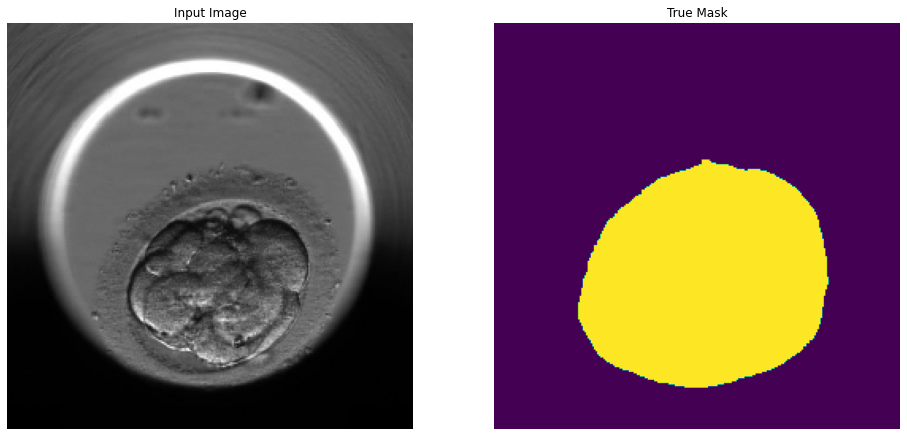

In [ ]:
title = ['Input Image', 'True Mask', 'Predicted Mask']
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].set_title('Input Image')
ax[0].imshow(array_to_img(train_input_imgs[0]))
ax[0].axis('off')

ax[1].set_title('True Mask')
ax[1].imshow(array_to_img(train_targets[0]))
ax[1].axis('off')

plt.show()

# U-NET

In [ ]:
def double_conv_block(x, n_filters):
  x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  return x

def downsample_block(x, n_filters):
  f = double_conv_block(x, n_filters)
  p = tf.keras.layers.MaxPool2D(2)(f)
  p = tf.keras.layers.Dropout(0.5)(p)
  return f, p

def upsample_block(x, conv_features, n_filters):
  x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
  if conv_features.shape[1] != x.shape[1]:
    limit = x.shape[1]
    conv_features = conv_features[:, 0:limit, 0:limit, :]
  x = tf.keras.layers.concatenate([x, conv_features])
  x = tf.keras.layers.Dropout(0.5)(x)
  x = double_conv_block(x, n_filters)
  return x

In [ ]:
def get_model():
  inputs = tf.keras.Input(shape=(256, 256, 3))
  # flipping horizontally and vertically to augment data
  data_augment = tf.keras.layers.RandomFlip(seed=42)(inputs)

  # encoder
  f1, p1 = downsample_block(data_augment, 32)
  f2, p2 = downsample_block(p1, 64)
  f3, p3 = downsample_block(p2, 128)
  f4, p4 = downsample_block(p3, 256)

  bottleneck = double_conv_block(p4, 512)

  # decoder
  u6 = upsample_block(bottleneck, f4, 256)
  u7 = upsample_block(u6, f3, 128)
  u8 = upsample_block(u7, f2, 64)
  u9 = upsample_block(u8, f1, 32)

  outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

  return unet_model

unet_model = get_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_2 (RandomFlip)     (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 32  896         ['random_flip_2[0][0]']          
                                )                                                                 
                                                                                              

Decrease batch size if Out-Of-Memory error is thrown

In [ ]:
unet_model.compile(optimizer="adam",
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("unet_embryo_mask_segmentation.keras",
                                       monitor='val_loss',
                                       mode='min',
                                       save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                     patience=20,
                                     mode="min")
]

history = unet_model.fit(train_input_imgs, train_targets,
                    epochs=200,
                    callbacks=callbacks,
                    batch_size=32,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/200
46/46 [==============================] - 57s 1s/step - loss: 0.6080 - accuracy: 0.7542 - val_loss: 0.4508 - val_accuracy: 0.7774
Epoch 2/200
46/46 [==============================] - 36s 793ms/step - loss: 0.4873 - accuracy: 0.7699 - val_loss: 0.4073 - val_accuracy: 0.7775
Epoch 3/200
46/46 [==============================] - 36s 782ms/step - loss: 0.4318 - accuracy: 0.7814 - val_loss: 0.3021 - val_accuracy: 0.8701
Epoch 4/200
46/46 [==============================] - 36s 790ms/step - loss: 0.3482 - accuracy: 0.8320 - val_loss: 0.2543 - val_accuracy: 0.9132
Epoch 5/200
46/46 [==============================] - 36s 783ms/step - loss: 0.3164 - accuracy: 0.8502 - val_loss: 0.2382 - val_accuracy: 0.9119
Epoch 6/200
46/46 [==============================] - 36s 780ms/step - loss: 0.3021 - accuracy: 0.8602 - val_loss: 0.2532 - val_accuracy: 0.8915
Epoch 7/200
46/46 [==============================] - 36s 778ms/step - loss: 0.2913 - accuracy: 0.8656 - val_loss: 0.2635 - val_accuracy: 0.

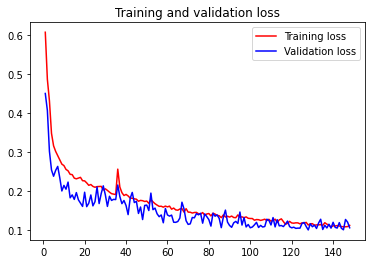

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

### Load the best model

In [ ]:
unet_model = tf.keras.models.load_model("unet_embryo_mask_segmentation.keras")

## Metric - Evaluating against validation set using IoU and F1 Score

In [ ]:
# Using masks to get IoU and F1 Score

def iou_coef(y_true, y_pred, smooth=1):
  intersection = tf.multiply(y_true, y_pred)
  union = tf.add(y_true, y_pred) - intersection
  iou = tf.math.reduce_mean((intersection + smooth) / (union + smooth))
  return iou * 100

def f1_score(y_true, y_pred, smooth=1):
  intersection = tf.multiply(y_true, y_pred)
  combined = tf.add(y_true, y_pred)
  f1 = tf.math.reduce_mean((2 * intersection + smooth)/(combined + smooth))
  return f1 * 100

*The following cell takes around 10 mins to execute*

In [ ]:
pred_masks = unet_model.predict(np.expand_dims(val_input_imgs, axis=0)[0])
pred_masks = np.rint(pred_masks).astype('uint8')
pred_masks = pred_masks[:, :, :, 1]
pred_masks = np.expand_dims(pred_masks, axis=3)

In [ ]:
iou = iou_coef(val_targets, pred_masks)
f1 = f1_score(val_targets, pred_masks)
print(f'IoU = {iou:.2f}% and F1 Score = {f1:.2f}%')

IoU = 98.32% and F1 Score = 98.32%


## Visualizing Masks

In [ ]:
def display_masks(num_of_imgs=1):
  idx = np.random.randint(low=0, high=len(val_input_imgs), size=num_of_imgs)
  print(idx)
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in idx:
    test_image = val_input_imgs[i]
    true_mask = val_targets[i]

    pred_mask = unet_model.predict(np.expand_dims(test_image, axis=0))[0]
    pred_mask = np.rint(pred_mask).astype('uint8')
    pred_mask = pred_mask[:, :, 1]
    pred_mask = np.expand_dims(pred_mask, axis=2)

    display_list = [test_image, true_mask, pred_mask]
    
    plt.figure(figsize=(24, 8))
    for j in range(3):
      plt.subplot(1, 3, j+1)
      if i==idx[0]: plt.title(title[j])
      plt.imshow(array_to_img(display_list[j]))
      plt.axis('off')
  plt.show()

[159 328 136]


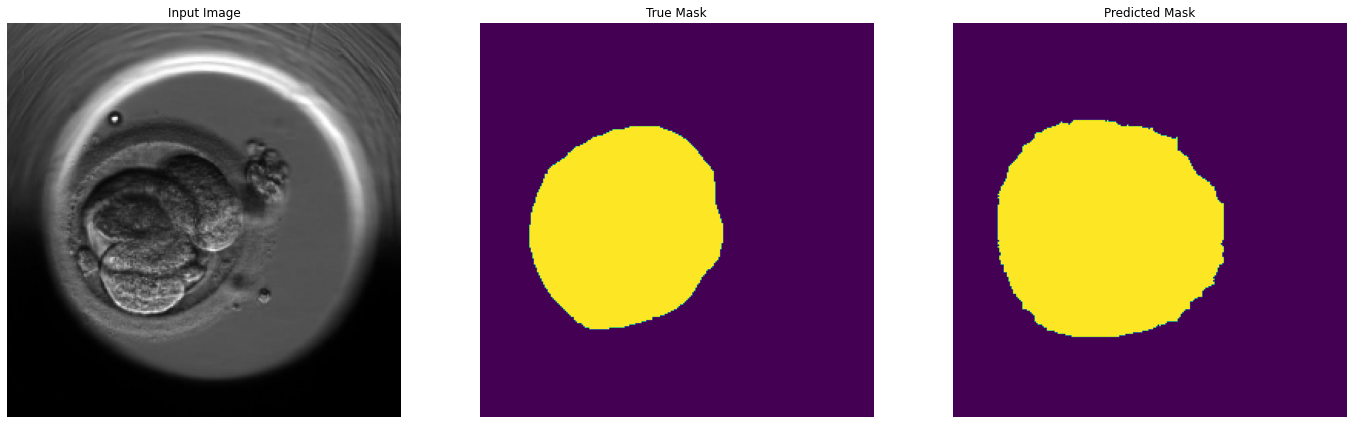

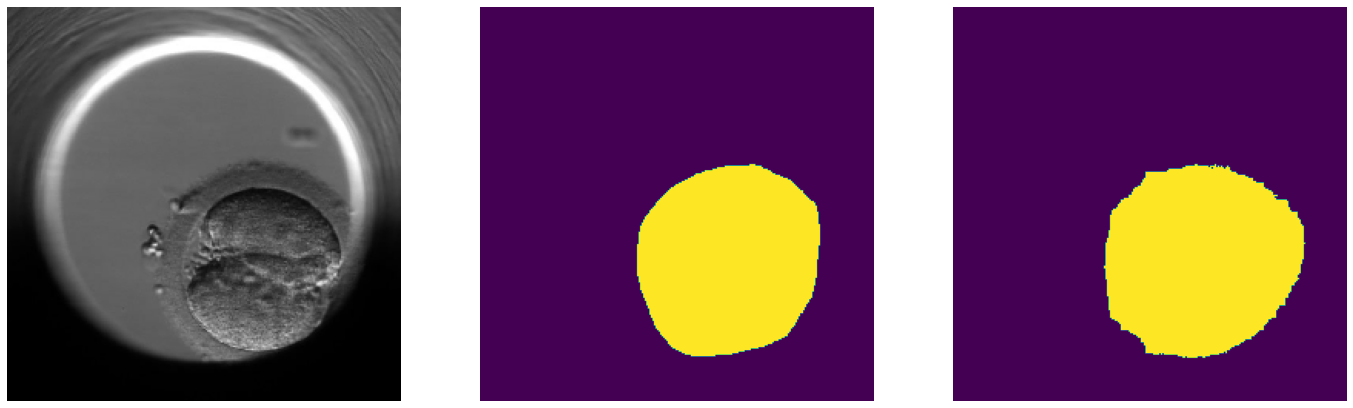

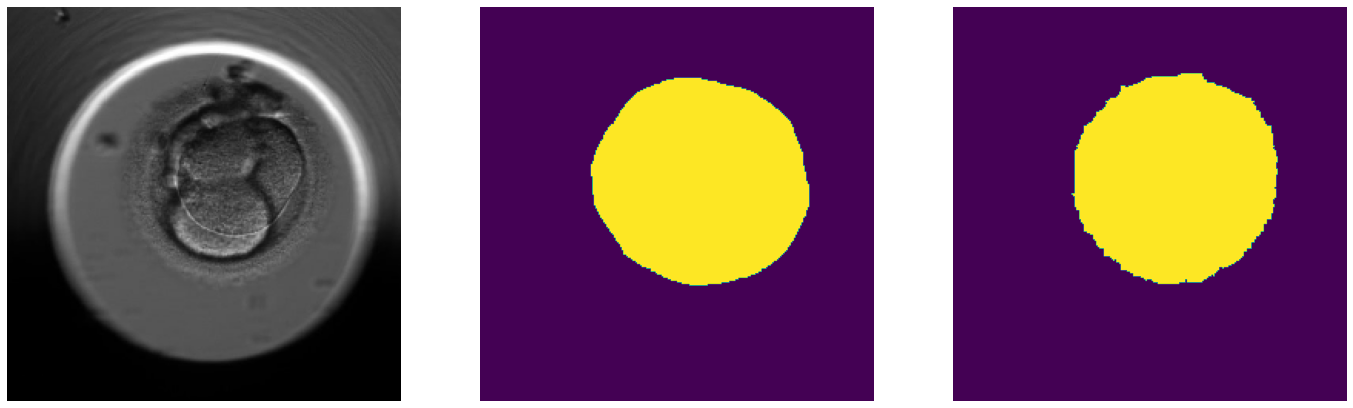

In [ ]:
num_of_imgs = 3
display_masks(num_of_imgs)

## Extracting Morula

In [ ]:
def display_morula(num_of_imgs=1):
  idx = np.random.randint(low=0, high=len(val_input_imgs), size=num_of_imgs)
  print(idx)
  title = ['Input Image', 'True Morula', 'Predicted Morula']
  count = 1
  for i in idx:
    test_image = val_input_imgs[i]
    true_mask = val_targets[i]

    pred_mask = unet_model.predict(np.expand_dims(test_image, axis=0))[0]
    pred_mask = np.rint(pred_mask).astype('uint8')
    pred_mask = pred_mask[:, :, 1]
    pred_mask = np.expand_dims(pred_mask, axis=2)

    iou = iou_coef(true_mask, pred_mask)
    f1 = f1_score(true_mask, pred_mask)
    print(f'Image no. {count} has IoU = {iou:.2f} and F1 Score = {f1:.2f}')
    count = count + 1

    test_image = (test_image * 255).astype('int')

    true_morula = cv2.bitwise_and(test_image, test_image, mask = true_mask)
    pred_morula = cv2.bitwise_and(test_image, test_image, mask = pred_mask)

    display_list = [test_image, true_morula, pred_morula]
    
    plt.figure(figsize=(24, 8))
    for j in range(3):
      plt.subplot(1, 3, j+1)
      if i==idx[0]: plt.title(title[j])
      plt.imshow(array_to_img(display_list[j]))
      plt.axis('off')
  plt.show()

[104 327  31]
Image no. 1 has IoU = 98.15 and F1 Score = 98.15
Image no. 2 has IoU = 99.31 and F1 Score = 99.31
Image no. 3 has IoU = 98.65 and F1 Score = 98.65


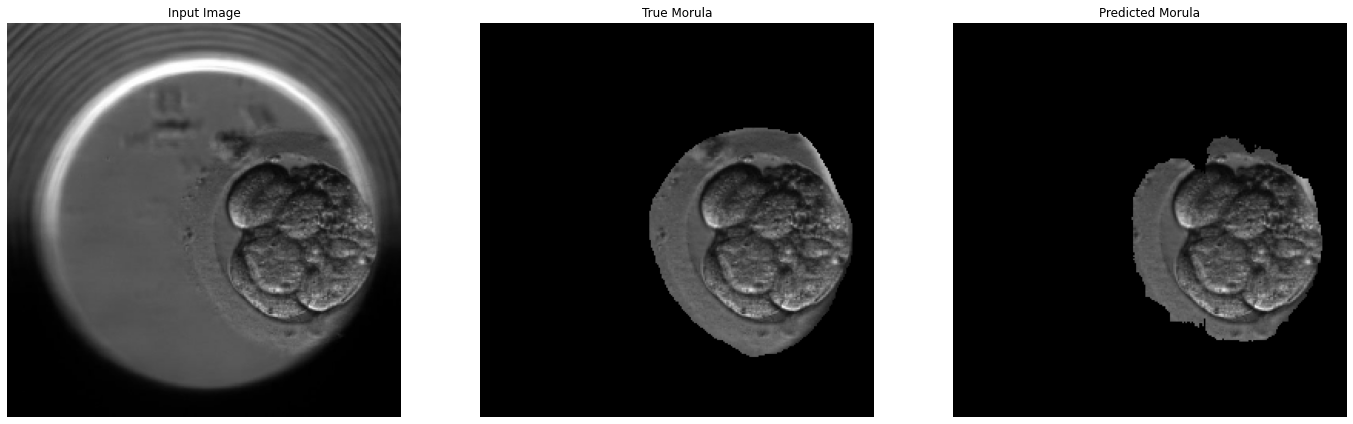

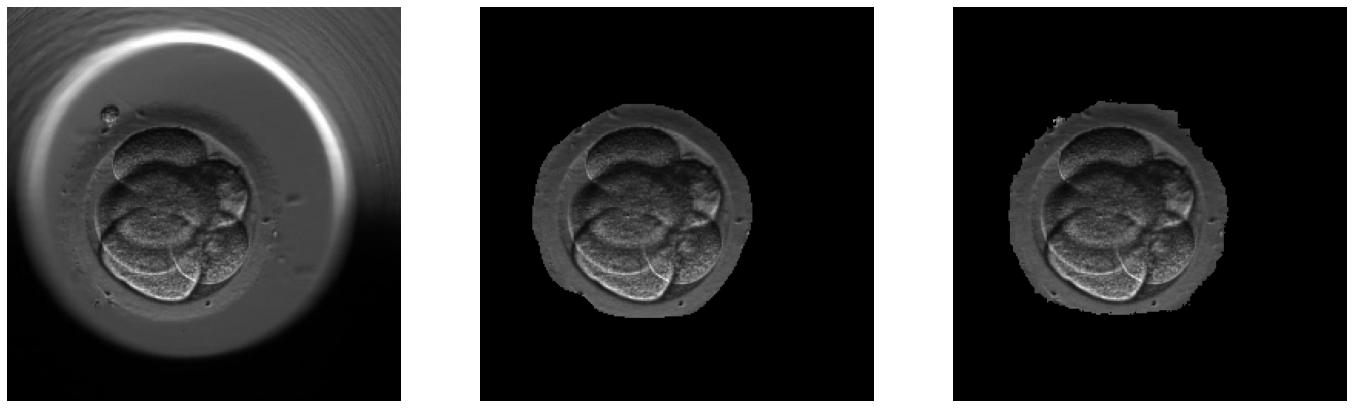

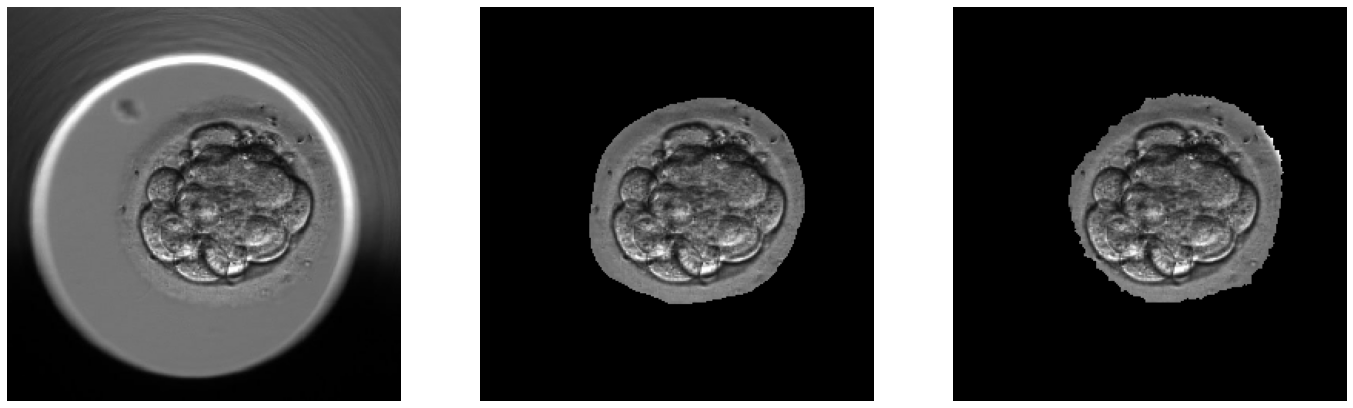

In [ ]:
num_of_imgs = 3
display_morula(num_of_imgs)